# **Blog Post 3**

With the rapid development of technology, we are exposed to large amount of all kinds of information all the time. Our generation knows that how difficult it is to extract effective information because of all the "fake" news. Wouldn't it be nice if we can create an algorithm that helps us detect fake news?

In this Blog Post, we will learn to develop and assess a fake news classifier using *Tensorflow*.

### TensorFlow

*TensorFlow* is designed to help you build models easily. It has a set of APIs that makes it simple to learn and implement machine learning. We can also easily train our models with TensorFlow. 

### Data Source 

Our data for this blog originally comes from the article:

- Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

This data can be accessed from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). However, the data we are using today has already been cleaned and split into training and testing sets.

### Important Packages

Before we start, here are the packages we will need for today's blog.

In [1]:
import tensorflow as tf
import numpy as np
import re
import string
import pandas as pd

# important tensorflow packages
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

# for splitting training, validation set
from sklearn.model_selection import train_test_split

# for embedding visualization
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

##§1. Acquire Training Data 




In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)
df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


As we can see, there are three important columns in this dataset, `title`, `text`, and `fake`. In the fake column, the data is already encoded to 0 (not fake news) and 1 (fake news), so we don't need to encode this column anymore. 

##§2. Make TensorFlow Datasets

TensorFlow Dataset has a special `Dataset` class that's easy to organize when writing data pipelines.

In this section, we want to write a function called `make_dataset` to construct our `Dataset`that has all the stopwrods removed from `text` and `title` and takes two inputs `text` and `title` of the form `("title", "text")`

In [3]:
# define stopwords 
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [4]:
def make_dataset(df, inputs):
  '''
  this function removes stopwords from desired columns and constructs tensorflow dataset with two input and one output
  input: 
        df - the dataframe of interest
        inputs - a tuple of the form ("title", "text")
  output: a tf.data.Dataset 
  '''
  # remove stopwords from text and title
  df = df[['text','title', "fake"]].apply(lambda x: [item for item in x if item not in stop])
  # construct tf dataset
  # first, construct a dictionary for the inputs 
  d = {}
  for input in inputs:
    d[input] = df[[input]]

  # construct dataset from a tuple of dictionaries
  # the first dictionary is the inputs 
  # the second dictionary specifies the output
  data = tf.data.Dataset.from_tensor_slices((d,{"fake" : df[["fake"]]}))

  # batch the dataset to increase the speed of training
  data = data.batch(100)
  
  return data


Now, we use the function we just wrote to construct our `Dataset`.

In [5]:
data = make_dataset(df, ("title", "text"))

Next, we'll split the dataset into training and validation sets. We want 20% of the dataset to use for validation.

In [6]:
# shuffle data 
data = data.shuffle(buffer_size = len(data))

In [7]:
# 80% of the dataset is for training 
train_size = int(0.8*len(data))

# so we have validation size of 0.2 approximately
train = data.take(train_size)
val = data.skip(train_size)

In [8]:
# check the size of training, validation, testing set
len(train), len(val)

(180, 45)

We have 180 batches in training set and 45 batches in validation set, which is exactly 0.8 : 0.2. We have successfully split the data into training and validation sets.

##§3. Create Models

As there are two potential predictors, there are three different potential models: model that focus on only the title of the article, the full text of the article, and both.

Which one is the most effective? 

To address this question, let's create 3 corresponding TensorFlow models.

1. In the first model, we use only the article title as an input.
2. In the second model, we use only the article text as an input.
3. In the third model, we use both the article title and the article text as input.

Compared with Keras sequential API, Keras functioanl API can handle shared layers and multiple inputs, which is exactly what we need for our inquery. For the first two models, we also don’t have 
to create new Datasets. Instead, just specify the inputs to the keras.Model appropriately, and TensorFlow will automatically ignore the unused inputs in the Dataset.


*standardization*

First, we want to standardize text by removing capitals and punctuation.

In [9]:
def standardization(input_data):
  '''
  this function taks a tensorflow dataset as input 
  and convert all text to lowercase and remove punctuation.
  '''
  lowercase = tf.strings.lower(input_data)
  no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
  return no_punctuation 

*vectorization*

Next, we want to represent text as a vector. 

In [10]:
# we only want to track the top 2000 distinct words
size_vocabulary = 2000

# vectorization layer learns what words are common 
vectorize_layer = TextVectorization(
    # standardize each sample
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

# adapt the vectorization layer to title and text in the training data
vectorize_layer.adapt(train.map(lambda x, y: x['title']))
vectorize_layer.adapt(train.map(lambda x, y: x['text']))

Now that we've prepared our data, it's time to construct our models. The first step is to specify the two inputs using `keras.Input` for our model. 

Note that both `title` and `text` contain just one entry for each news, so the shapes are `(1,)`. 

In [11]:
# inputs

title_input = keras.Input(
    shape = (1,), 
    # name for us to remember for later
    name = "title",
    # type of data contained
    dtype = "string"
)

text_input = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

*Hiden Layers*

Let's now write a pipeline for the titles and text. Since `title` and `text` are two different pieces of text but share similar vocabulary, we can use shared layers to encode inputs.

In [89]:
# shared embedding layer
shared_embedding = layers.Embedding(size_vocabulary, 20, name = "embedding")

# pipeline for title
title_features = vectorize_layer(title_input)
title_features = shared_embedding(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

#pipeline for text
text_features = vectorize_layer(text_input)
text_features = shared_embedding(text_features)
# the dropout rate is higher because lower rate led to overfitting by experiments
text_features = layers.Dropout(0.7)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.5)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

Although it looks like we are performing vectorization on inputs now, the vectorization actually won't take place until we actually run the model.

Now we can specify the respective output layers for three models. For the last model, we will need to `concatenate` the the ouput of `title` pipeline with the output of the `text` pipeline.

In [90]:
# the name of the output layer matches the key corresponding to the target data

# output layer for model1 that only focus on title
title_output = layers.Dense(2,name='fake')(title_features)

# output layer for model2 that only focus on text
text_output = layers.Dense(2,name='fake')(text_features)

In [91]:
main = layers.concatenate([title_features, text_features], axis = 1)
main = layers.Dense(32, activation= "relu")(main)

# output layer for model3 that focus on both
output = layers.Dense(2, name = "fake")(main)

It's time to create our models! We can do so by specifying the input(s) and output. The `plot_model` function provides an easy way to visually examine the structure of our model, so it's nice to take a look. After compile our model, we can start training it.

### Model 1

In [92]:
# speficy the input and output for model 1
model1 = keras.Model(
    inputs = title_input,
    outputs = title_output
)

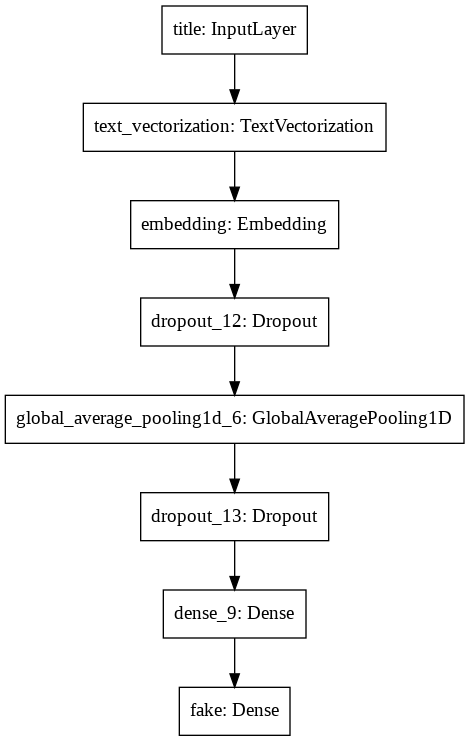

In [93]:
# check the structure of model 1
keras.utils.plot_model(model1)

In [94]:
# compile the model
model1.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [95]:
# fit model 1
history = model1.fit(train, 
                    validation_data=val,
                    epochs = 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning:

Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.



180/180 [==============================] - 2s 10ms/step - loss: 0.6920 - accuracy: 0.5198 - val_loss: 0.6853 - val_accuracy: 0.5233
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.6740 - accuracy: 0.6078 - val_loss: 0.5664 - val_accuracy: 0.8676
Epoch 3/50
180/180 [==============================] - 2s 9ms/step - loss: 0.5000 - accuracy: 0.8632 - val_loss: 0.3182 - val_accuracy: 0.8978
Epoch 4/50
180/180 [==============================] - 2s 9ms/step - loss: 0.3036 - accuracy: 0.8897 - val_loss: 0.2483 - val_accuracy: 0.9093
Epoch 5/50
180/180 [==============================] - 2s 9ms/step - loss: 0.2378 - accuracy: 0.9118 - val_loss: 0.2096 - val_accuracy: 0.9238
Epoch 6/50
180/180 [==============================] - 2s 9ms/step - loss: 0.2140 - accuracy: 0.9201 - val_loss: 0.1836 - val_accuracy: 0.9316
Epoch 7/50
180/180 [==============================] - 2s 9ms/step - loss: 0.2005 - accuracy: 0.9231 - val_loss: 0.1858 - val_accuracy: 0.9278
Epoch 8/50
180/1

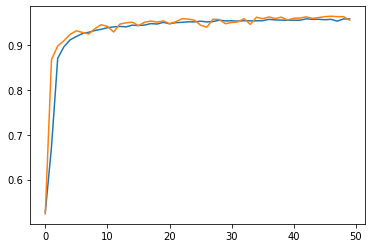

In [96]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

Based on the training log and the plogt, we can see that model 1 can reach validation accuracy of around 96%, which is pretty good! 

### Model 2

In [97]:
# specify the input and ouput for model 2
model2 = keras.Model(
    inputs = text_input,
    outputs = text_output
)

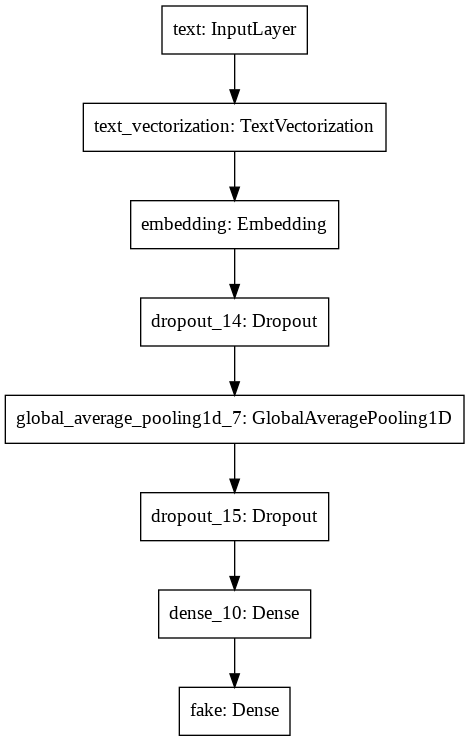

In [98]:
# take a look at the structure of model 2
keras.utils.plot_model(model2)

In [99]:
# compile model 2
model2.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [100]:
# fit model 2
history = model2.fit(train, 
                    validation_data=val,
                    epochs = 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning:

Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.



180/180 [==============================] - 5s 22ms/step - loss: 0.6804 - accuracy: 0.5270 - val_loss: 0.5843 - val_accuracy: 0.6791
Epoch 2/50
180/180 [==============================] - 4s 20ms/step - loss: 0.5439 - accuracy: 0.7368 - val_loss: 0.2810 - val_accuracy: 0.9107
Epoch 3/50
180/180 [==============================] - 4s 20ms/step - loss: 0.2872 - accuracy: 0.8900 - val_loss: 0.1753 - val_accuracy: 0.9389
Epoch 4/50
180/180 [==============================] - 4s 20ms/step - loss: 0.1965 - accuracy: 0.9210 - val_loss: 0.1403 - val_accuracy: 0.9624
Epoch 5/50
180/180 [==============================] - 4s 20ms/step - loss: 0.1642 - accuracy: 0.9425 - val_loss: 0.1427 - val_accuracy: 0.9589
Epoch 6/50
180/180 [==============================] - 4s 20ms/step - loss: 0.1470 - accuracy: 0.9522 - val_loss: 0.1169 - val_accuracy: 0.9700
Epoch 7/50
180/180 [==============================] - 4s 21ms/step - loss: 0.1374 - accuracy: 0.9579 - val_loss: 0.1120 - val_accuracy: 0.9722
Epoch 8/50

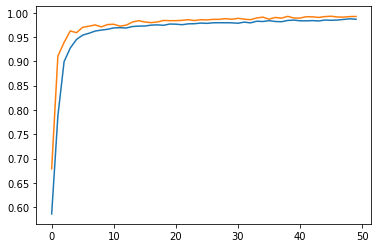

In [101]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

By reading the training log and the plot, the validation accuracy is able to reach above 98% consistently. This is quite impressive! 

### Model 3

In [102]:
# specify the inputs and output for model 3
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

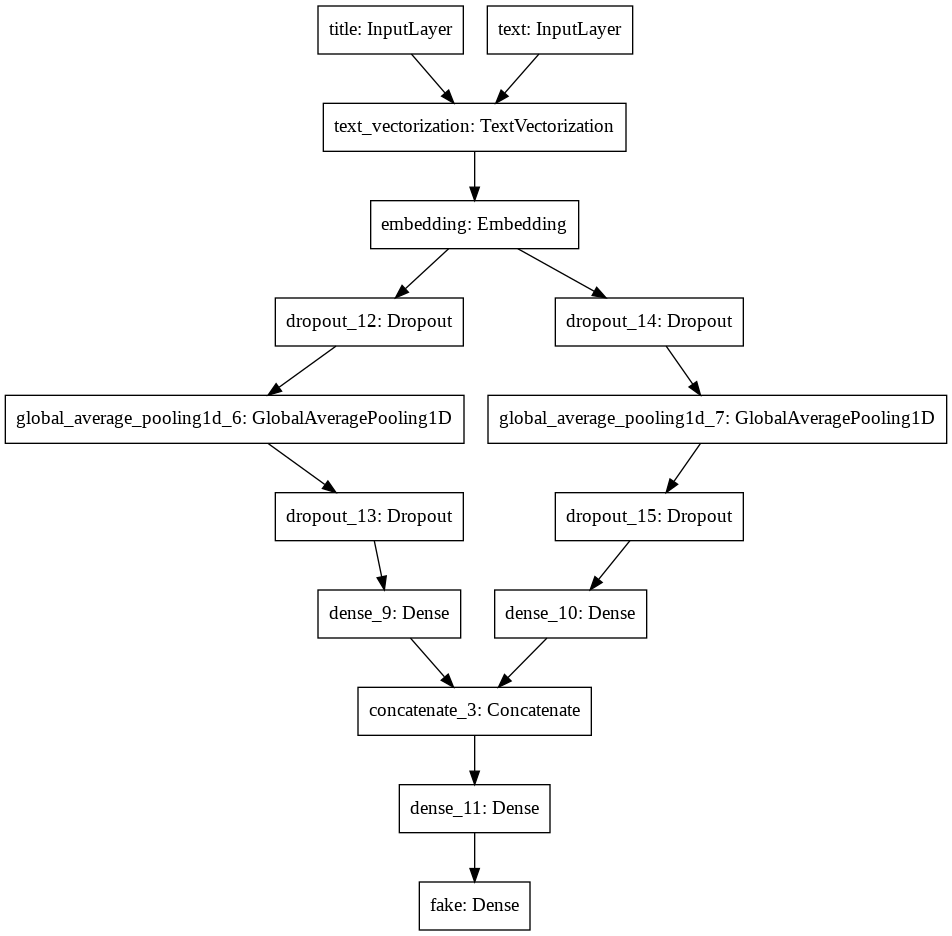

In [103]:
# take a look at the structure of model 3
keras.utils.plot_model(model3)

In [104]:
# compile model 3
model3.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [105]:
# train model 3
history = model3.fit(train, 
                    validation_data=val,
                    epochs = 50)

Epoch 1/50
180/180 [==============================] - 6s 26ms/step - loss: 0.2053 - accuracy: 0.9612 - val_loss: 0.0289 - val_accuracy: 0.9926
Epoch 2/50
180/180 [==============================] - 4s 25ms/step - loss: 0.0408 - accuracy: 0.9870 - val_loss: 0.0188 - val_accuracy: 0.9942
Epoch 3/50
180/180 [==============================] - 5s 25ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0195 - val_accuracy: 0.9951
Epoch 4/50
180/180 [==============================] - 4s 25ms/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 0.0191 - val_accuracy: 0.9949
Epoch 5/50
180/180 [==============================] - 4s 24ms/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 0.0141 - val_accuracy: 0.9949
Epoch 6/50
180/180 [==============================] - 5s 25ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0156 - val_accuracy: 0.9936
Epoch 7/50
180/180 [==============================] - 5s 25ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 0.0123 - val_accuracy: 0.9964

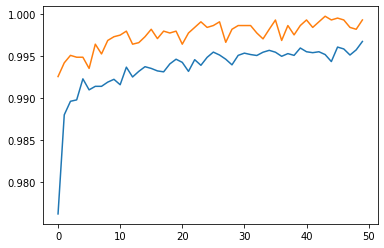

In [106]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

Model 3 is able to consistently reach a validation performance of 99% by the training log and plot. Hence, we pick Model 3 to be our final model, i.e. the model that focuses on both the `text` and `title`. 

##§4. Model Evaluation

From last section, our best model focuses only on the `text`. Now let's test this model's performance on unseen test data. 

In [107]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test = pd.read_csv(test_url)

In [108]:
test = make_dataset(test, ("title", "text"))

In [109]:
model3.evaluate(test)

225/225 [==============================] - 4s 16ms/step - loss: 0.0312 - accuracy: 0.9915


[0.03123784437775612, 0.9914918541908264]

The accuracy is 99%! We have created a pretty good fake news detector. 

##§5. Visualizing Embeddings

We can take a step further to learn about which words are learned by our model to be good indicators of fake news by visualizing embeddings.

In [110]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [111]:
len(weights[0]) # the dimension of embedding is 20

20

In [112]:
from sklearn.decomposition import PCA
# reduce the dimension to 2
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

# a dataframe of our result 
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

Now we are ready to see the plot.

In [113]:
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

The graph is stretched horizontally and slightly vertically. By hovering the cursor on some of the points, we see `reportedly`, `myanmar`, `rohingya`, `trumps`, `donald`, `barack` are all stronger indicators for whether a news is fake or not. 